In [1]:
#Depois fazer o import apenas das partes necessárias das bibliotecas
import schemdraw
import schemdraw.elements as elm
import numpy as np
from math import atan

In [97]:
class Circuito:
    def __init__(self):
        self.elements =0 # Variável que conta a quantidade de elementos
        self.elements_list =[] #List that saves the elements
        self.nodes = set()   #Set() faz com que os nós armazenados no conjunto sejam únicos
        self.node_map={}
        self.reference_node=0
        self.currents ={}
        self.vsource_wire={}
        schemdraw.config(inches_per_unit=1.3)


    def element(self, Element: str, Start: tuple, End: tuple, Valor: float=0, Label: str = None):
        self.elements_list.append([Element, Start, End, Valor, Label])
        self.elements +=1
        #Adiciona nós aos conjuntos de nós
        self.nodes.add(Start)
        self.nodes.add(End)



    def exibir_elementos(self):
        for i, elemento in enumerate(self.elements_list):
            print(f"Elemento {i+1}: {elemento}")


    def draw(self):
        with schemdraw.Drawing(figsize=(15,15)) as d:
            for iten in self.elements_list:
                direction='bot'
                x1,y1 = iten[1]
                x2,y2 = iten[2]
                if(x2==x1):
                    direction='righ'

                if(iten[0]=='Resistor'):
                            d.add(elm.Resistor(scale=0.5).endpoints(iten[1], iten[2]).label( str(iten[3])+" Ω",loc='top', fontsize=8).label(iten[4],loc='bot', fontsize=8))
                elif(iten[0]=='Capacitor'):
                        valor_capacitor = f"{int(iten[3].imag)}j" if iten[3].imag % 1 == 0 else f"{iten[3].imag}j"
                        C= d.add(elm.Capacitor(scale=0.7).endpoints(iten[1], iten[2]).label(valor_capacitor + " Ω", loc='top', fontsize=8).label(iten[4], loc='bot', fontsize=8))
                elif(iten[0]=='Inductor'):
                        d.add(elm.Inductor(scale=0.7).endpoints(iten[1], iten[2]).label(str(iten[3])+" Ω",loc='top', fontsize=8).label(iten[4],loc='bot', fontsize=8))
                elif(iten[0] == 'Voltage Source'):
                        d.add(elm.SourceV(scale=0.7).endpoints(iten[1], iten[2]).label(str(iten[3])+"V",loc='top', fontsize=8).label(iten[4],loc='bot', fontsize=8)),
                elif(iten[0] == 'Current Source'):
                        d.add(elm.SourceI(scale=0.7).endpoints(iten[1], iten[2]).label(str(iten[3])+"A",loc='top', fontsize=8).label(iten[4],loc='bot', fontsize=8))
                elif(iten[0] == 'Wire'):
                        d.add(elm.Line(scale=0.5).endpoints(iten[1], iten[2]))

    def map_nodes(self):
        #Criar um mapeamento para associar cada nó a um índice
        self.node_map = {}
        #Aqui vamos preencher o dicionário node_map
        # enumerate retorna
        for idx, node in enumerate(self.nodes):
            self.node_map[node] = idx #O nó é a chave do dicionário e o índice o valor
        #print("Mapeamento de nós:", self.node_map)


    def montar_equacoes(self):
        self.map_nodes()
        n = len(self.nodes)
        G = np.zeros((n, n), dtype=complex) #Matriz condutância
        I = np.zeros(n, dtype=complex) #Matriz de correntes

        for elm in self.elements_list:
          #print(elm)
          Element, Start, End, Valor, Label = elm
          idx_start=self.node_map[Start]
          idx_end=self.node_map[End]

          if(Element=='Current Source'):
            I[idx_start] -= Valor
            I[idx_end] += Valor

          if(Element == 'Voltage Source' ):
            G = np.vstack([G, np.zeros(G.shape[1])])  # Adiciona uma nova linha
            G = np.hstack([G, np.zeros((G.shape[0], 1))])  # Adiciona uma nova coluna
            G[-1, idx_start] = -1
            G[-1, idx_end] = +1
            G[idx_start,-1] =-1
            G[idx_end,-1] =+1
            I = np.append(I, Valor)  # Adiciona o valor da fonte ao vetor de correntes
            self.vsource_wire[Label] = I.shape[0]

          elif(Element == 'Wire'):
            G = np.vstack([G, np.zeros(G.shape[1])])  # Adiciona uma nova linha
            G = np.hstack([G, np.zeros((G.shape[0], 1))])  # Adiciona uma nova coluna
            G[-1, idx_start] = -1
            G[-1, idx_end] = +1
            G[idx_start,-1] =-1
            G[idx_end,-1] =+1
            I = np.append(I, 0)  # Adiciona o valor da fonte ao vetor de correntes
            

          elif(Element == 'Resistor' or Element == 'Inductor' or Element == 'Capacitor' ):
            G[idx_start, idx_start] += 1 / Valor
            G[idx_end, idx_end] += 1 / Valor
            G[idx_start, idx_end] -= 1 / Valor
            G[idx_end, idx_start] -= 1 / Valor

        return G, I

    def resolver_circuito(self):
        G, I = self.montar_equacoes()
        # Escolher um nó de referência, por exemplo, o primeiro nó mapeado
        ref_node = self.reference_node

        # Reduzir a matriz removendo a linha e a coluna do nó de referência
        G_reduced = np.delete(np.delete(G, ref_node, axis=0), ref_node, axis=1)
        I_reduced = np.delete(I, ref_node)

        try:
            # Resolver o sistema reduzido G * V = I
            V_reduced = np.linalg.solve(G_reduced, I_reduced)

            # Reconstruir o vetor completo de tensões
            self.V = np.insert(V_reduced, ref_node, 0)  # Define a tensão do nó de referência como 0
            #print("Tensões nos nós:", self.V)
        except np.linalg.LinAlgError as e:
            print("Erro ao resolver o sistema:", e)
            self.V = None
        return self.V

    def set_reference(self,reference: int):
        self.reference_node = reference

    
    def mostrar_matriz_condutancia(self):
        G, I = self.montar_equacoes()
        linhas,colunas = G.shape
        for i in range (linhas):
          for j in range (colunas):
            print("{:.3f}".format(G[i,j]), "|",end=" ")
          print(" ")

    def calcular_correntes(self):
        for elm in self.elements_list:
            Element, Start, End, Valor, Label = elm
            idx_start=self.node_map[Start]
            idx_end=self.node_map[End]
            if Element =='Resistor' or Element =="Capacitor"  or  Element =="Inductor":
                self.currents[Label] = (self.V[idx_start]-self.V[idx_end])/Valor
            elif Element == 'Voltage Source':
                #Retorna o indice na da matriz V que representa 
                indice = self.vsource_wire[Label]
                self.currents[Label] =  self.V[indice-1]
        

    def get_current(self, Label: str):
        self.calcular_correntes()
        #print("Corrente ",self.currents[Label])
        return(self.currents[Label])

    def current_complex(self,valor):
        complex_ret = valor
        angulo = atan(complex_ret.imag/complex_ret.real)
        angulo = angulo*180/np.pi
        modulo= complex_ret.real
        return(modulo,angulo)
    def ponto_medio(self,start,end):
        x1,y1 = start
        x2,y2 = end
        return( (x2+x1)/2 +0.6, (y2+y1)/2   )

    def draw_with_currents(self,Label: list = [None]):
            with schemdraw.Drawing(figsize=(15,15)) as d:
                for iten in self.elements_list:
                    direction_elm='bot'
                    x1,y1 = iten[1]
                    x2,y2 = iten[2]
                    if(x2==x1):
                        direction_elm='bot'

    
                    if(iten[0]=='Resistor'):
                        modulo,angulo=self.current_complex(self.get_current(iten[4]))
                        R=d.add(elm.Resistor(scale = 0.5).endpoints(iten[1], iten[2]).label( str(iten[3])+" Ω",loc='top', fontsize=8))
                        for name in Label:
                            if(iten[4]==name or name==None):
                                d.add(elm.CurrentLabelInline(direction='in',headlength=0.15,headwidth=0.15,ofst=0.5).at(R).label("{:.2f}".format(modulo)+"∠"+ "{:.2f}".format(angulo)+" A",fontsize=8  ) )
                                # d.add(elm.CurrentLabel(length=0.7,top=False).at(R).label("{:.2f}".format(modulo)+"∠"+ "{:.2f}".format(angulo)+" A",fontsize=8  ) )
                    elif(iten[0]=='Capacitor'):
                        modulo,angulo=self.current_complex(self.get_current(iten[4]))
                        valor_capacitor = f"{int(iten[3].imag)}j" if iten[3].imag % 1 == 0 else f"{iten[3].imag}j"
                        C= d.add(elm.Capacitor(scale = 0.7).endpoints(iten[1], iten[2]).label(valor_capacitor + " Ω", loc='top', fontsize=8))
                        for name in Label:
                            if(iten[4]==name or name==None):
                                d.add(elm.CurrentLabelInline(direction='in',headlength=0.15,headwidth=0.15,ofst=0.5).at(C).label("{:.2f}".format(modulo)+"∠"+ "{:.2f}".format(angulo)+" A",fontsize=8  ) )
                                # d.add(elm.CurrentLabel(length=0.7,top=False).at(C).label("{:.2f}".format(modulo)+"∠"+ "{:.2f}".format(angulo)+" A",fontsize=8  ) )
                    elif(iten[0]=='Inductor'):
                        modulo,angulo=self.current_complex(self.get_current(iten[4]))
                        L = d.add(elm.Inductor(scale = 0.7).endpoints(iten[1], iten[2]).label(str(iten[3])+" Ω",loc='top', fontsize=8))
                        for name in Label:
                            if(iten[4]==name or name==None):
                                d.add(elm.CurrentLabelInline(direction='in',headlength=0.15,headwidth=0.15,ofst=0.5).at(L).label("{:.2f}".format(modulo)+"∠"+ "{:.2f}".format(angulo)+" A",fontsize=8  ) )
                                # d.add(elm.CurrentLabel(length=0.7,top=False).at(L).label("{:.2f}".format(modulo)+"∠"+ "{:.2f}".format(angulo)+" A",fontsize=8  ) )
                    elif(iten[0] == 'Voltage Source'):
                        modulo,angulo=self.current_complex(self.get_current(iten[4]))
                        V=d.add(elm.SourceV(scale = 0.7).endpoints(iten[1], iten[2]).label(str(iten[3])+"V",loc='top', fontsize=8))
                        for name in Label:
                            if(iten[4]==name or name==None):
                                at = self.ponto_medio(iten[1],iten[2])
                                d.add(elm.CurrentLabelInline(direction='out',headlength=0.15,headwidth=0.15,ofst=0.5).at(V).label("{:.2f}".format(modulo)+"∠"+ "{:.2f}".format(angulo)+" A",fontsize=8  ) )
                                # d.add(elm.CurrentLabel(length=0.7,top=False,reverse=True).at(V).label("{:.2f}".format(modulo)+"∠"+ "{:.2f}".format(angulo)+" A",fontsize=8  ) )
                    elif(iten[0] == 'Current Source'):
                        d.add(elm.SourceI(scale = 0.7).endpoints(iten[1], iten[2]).label(str(iten[3])+"A",loc='top', fontsize=8))
                    elif(iten[0] == 'Wire'):
                        d.add(elm.Line(scale = 0.5).endpoints(iten[1], iten[2]))

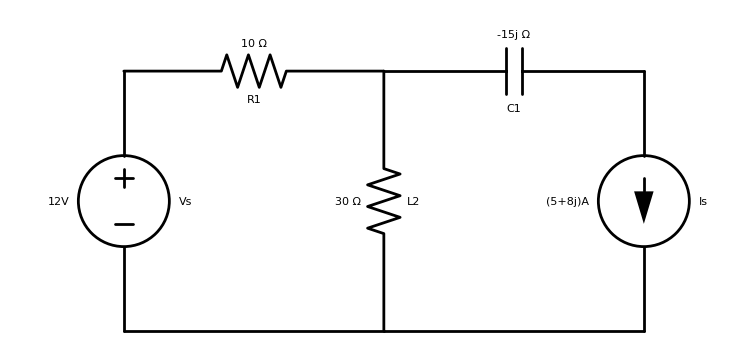

In [98]:
circuito=Circuito()
circuito.element("Voltage Source",(0,-2),(0,0),12,'Vs')
circuito.element('Resistor',(0,0),(2,0),10,"R1")
circuito.element('Capacitor',(2,0),(4,0),-15j,"C1")
circuito.element('Current Source',(4,0),(4,-2),5+8j,'Is')
#circuito.element('Wire',(4,-2),(0,-2))
circuito.element('Wire',(4,-2),(2,-2))
circuito.element('Wire',(2,-2),(0,-2))
#circuito.element('Resistor',(2,0),(0,-2),2)
circuito.element("Resistor",(2,0),(2,-2),30,"L2")
circuito.set_reference(4)
circuito.draw()
#circuito.map_nodes()
#G,I=circuito.montar_equacoes()
#circuito.mostrar_matriz_condutancia()
V=circuito.resolver_circuito()

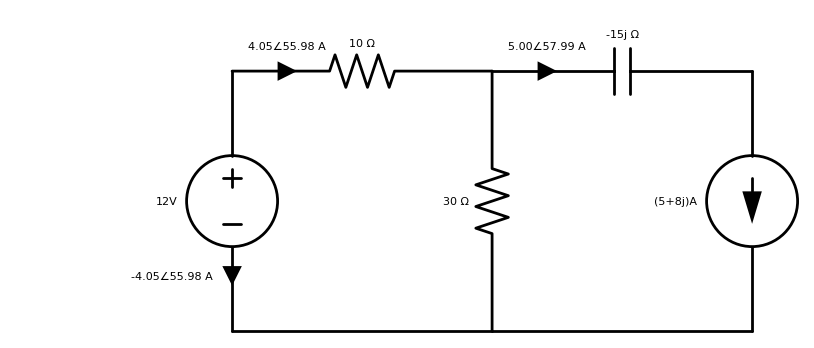

In [99]:
circuito.draw_with_currents(["R1","Vs","C1"])


In [45]:
x=(2,3)
y=(3,2)
z=circuito.ponto_medio(x,y)

In [46]:
print(z)

(2.5, 2.5)
